# Libraries

In [1]:
# Basic Data Processing and Analysis Libraries
import numpy as np
import pandas as pd
import statistics
from collections import Counter
from os.path import exists
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing and NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning - Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler

# Machine Learning - Models
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Parallel Processing
from pandarallel import pandarallel

# Initialize parallel processing
pandarallel.initialize(progress_bar=False)

# Set all random seeds for reproducibility
RANDOM_SEED = 69
np.random.seed(RANDOM_SEED)
import random
random.seed(RANDOM_SEED)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

First few rows of training set:
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intellig

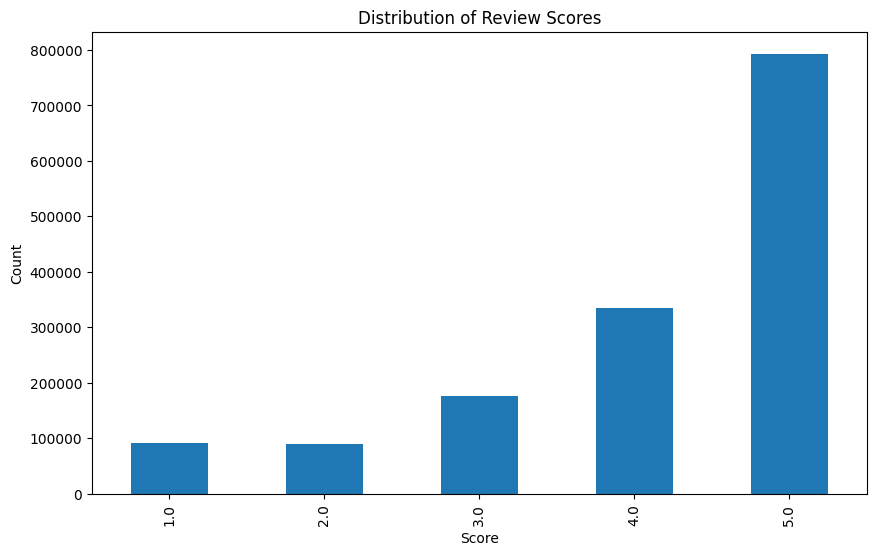

In [2]:
# Load datasets
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print("\nFirst few rows of training set:")
print(trainingSet.head())
print("\nFirst few rows of test set:")
print(testingSet.head())

# Plot score distribution
plt.figure(figsize=(10, 6))
trainingSet['Score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


# Text Length Analysis

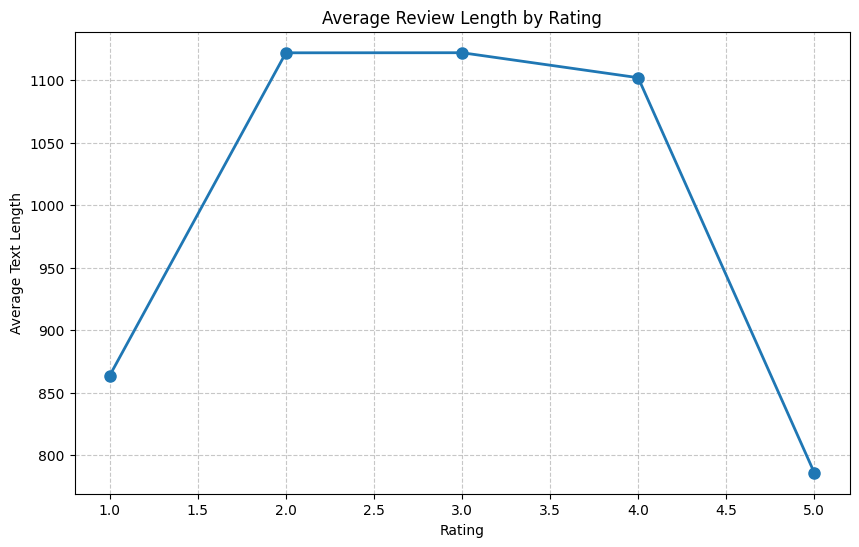

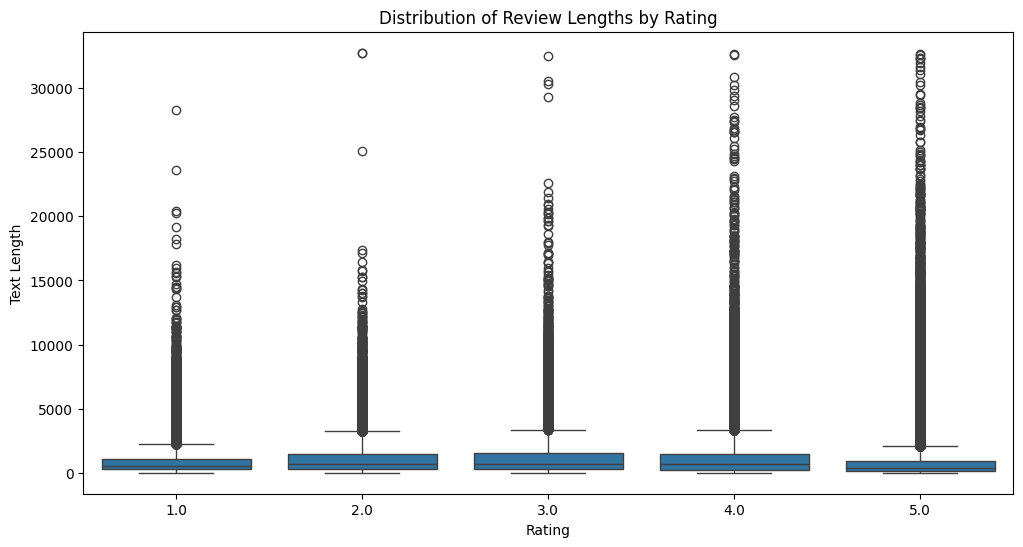

In [3]:
# Calculate text lengths
trainingSet['text_length'] = trainingSet['Text'].fillna('').apply(len)

# Calculate average text length per rating
avg_length_by_rating = trainingSet.groupby('Score')['text_length'].mean().reset_index()

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(avg_length_by_rating['Score'], avg_length_by_rating['text_length'], 
         marker='o', linewidth=2, markersize=8)
plt.title('Average Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Text Length')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Optional: Add box plot to show distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='Score', y='text_length', data=trainingSet)
plt.title('Distribution of Review Lengths by Rating')
plt.xlabel('Rating')
plt.ylabel('Text Length')
plt.show()

# Adding Features

Processing training set...
Adding features to dataframe...
Extracting text features in parallel...
Features added successfully!
Available columns: ['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score', 'text_length', 'text_word_count', 'summary_word_count', 'text_avg_word_length', 'summary_avg_word_length', 'text_sentence_count', 'summary_sentence_count', 'text_avg_sentence_length', 'summary_avg_sentence_length', 'text_long_words_ratio', 'summary_long_words_ratio', 'text_sentiment_neg', 'summary_sentiment_neg', 'text_sentiment_pos', 'summary_sentiment_pos', 'text_sentiment_neu', 'summary_sentiment_neu', 'text_sentiment_compound', 'summary_sentiment_compound', 'text_exclamation_ratio', 'text_question_ratio', 'text_caps_ratio', 'helpfulness_ratio', 'user_avg_score', 'user_review_count', 'product_avg_score', 'product_review_count']

Processing test set...
Adding features to dataframe...
Extracting text features in parallel...
Fe

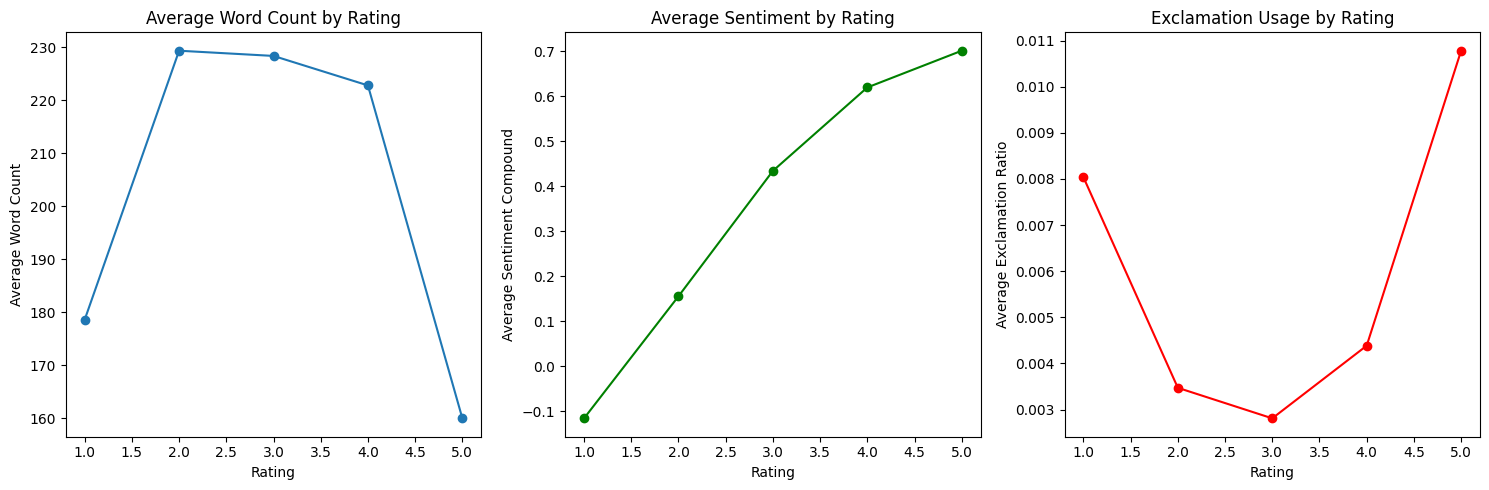

In [4]:
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop_words]
        return ' '.join(tokens)
    return ''

def extract_text_features(df):
    """Enhanced text feature extraction with parallel processing"""
    
    # Initialize VADER sentiment analyzer
    from nltk.sentiment import SentimentIntensityAnalyzer
    from nltk.tokenize import sent_tokenize, word_tokenize  # Move imports here
    import statistics
    
    sia = SentimentIntensityAnalyzer()
    
    def analyze_text(text):
        # Import required NLTK functions inside the function
        from nltk.tokenize import sent_tokenize, word_tokenize
        
        if not isinstance(text, str):
            return {
                'word_count': 0,
                'avg_word_length': 0,
                'sentence_count': 0,
                'avg_sentence_length': 0,
                'long_words_ratio': 0,
                'sentiment_neg': 0,
                'sentiment_pos': 0,
                'sentiment_neu': 0,
                'sentiment_compound': 0
            }
            
        # Basic text statistics
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        
        # Word-based features
        word_count = len(words)
        avg_word_length = statistics.mean([len(word) for word in words]) if words else 0
        long_words = sum(1 for word in words if len(word) > 6)
        long_words_ratio = long_words / word_count if word_count > 0 else 0
        
        # Sentence-based features
        sentence_count = len(sentences)
        avg_sentence_length = statistics.mean([len(sent.split()) for sent in sentences]) if sentences else 0
        
        # Sentiment scores
        sentiment_scores = sia.polarity_scores(text)
        
        return {
            'word_count': word_count,
            'avg_word_length': avg_word_length,
            'sentence_count': sentence_count,
            'avg_sentence_length': avg_sentence_length,
            'long_words_ratio': long_words_ratio,
            'sentiment_neg': sentiment_scores['neg'],
            'sentiment_pos': sentiment_scores['pos'],
            'sentiment_neu': sentiment_scores['neu'],
            'sentiment_compound': sentiment_scores['compound']
        }
    
    print("Extracting text features in parallel...")
    
    # Extract features from both Text and Summary using parallel processing
    text_features = df['Text'].fillna('').parallel_apply(analyze_text)
    summary_features = df['Summary'].fillna('').parallel_apply(analyze_text)
    
    # Add text features
    for feature in text_features.iloc[0].keys():
        df[f'text_{feature}'] = text_features.apply(lambda x: x[feature])
        df[f'summary_{feature}'] = summary_features.apply(lambda x: x[feature])
    
    # Add special character ratios in parallel
    df['text_exclamation_ratio'] = df['Text'].fillna('').parallel_apply(lambda x: x.count('!')) / df['text_word_count'].replace(0, 1)
    df['text_question_ratio'] = df['Text'].fillna('').parallel_apply(lambda x: x.count('?')) / df['text_word_count'].replace(0, 1)
    df['text_caps_ratio'] = df['Text'].fillna('').parallel_apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
    )
    
    return df

def add_features_to(df, training_stats=None):
    print("Adding features to dataframe...")
    
    # Add enhanced text features
    df = extract_text_features(df)
    
    # Helpfulness ratio
    df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)
    df['helpfulness_ratio'] = df['helpfulness_ratio'].fillna(0)
    
    if training_stats is None:
        # User statistics
        user_stats = df.groupby('UserId').agg({
            'Score': ['mean', 'count']
        }).fillna(0)
        user_stats.columns = ['user_avg_score', 'user_review_count']
        df = df.merge(user_stats, left_on='UserId', right_index=True, how='left')
        
        # Product statistics
        product_stats = df.groupby('ProductId').agg({
            'Score': ['mean', 'count']
        }).fillna(0)
        product_stats.columns = ['product_avg_score', 'product_review_count']
        df = df.merge(product_stats, left_on='ProductId', right_index=True, how='left')
    else:
        user_stats, product_stats = training_stats
        df = df.merge(user_stats, left_on='UserId', right_index=True, how='left')
        df = df.merge(product_stats, left_on='ProductId', right_index=True, how='left')
        df = df.fillna(0)  # Fill NaN values for new users/products
    
    print("Features added successfully!")
    print("Available columns:", df.columns.tolist())
    
    if training_stats is None:
        return df, (user_stats, product_stats)
    return df

# Force regenerate features
force_regenerate = True

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv') and not force_regenerate:
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the training DataFrame
    print("Processing training set...")
    train_with_features, training_stats = add_features_to(trainingSet.copy())
    
    # Get only rows where Score is not null for training
    X_train = train_with_features[train_with_features['Score'].notnull()].copy()
    
    # Merge test set with training data for feature calculation
    print("\nProcessing test set...")
    test_with_features = pd.merge(
        testingSet,
        trainingSet[['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'HelpfulnessNumerator', 'HelpfulnessDenominator']],
        on='Id',
        how='left'
    )
    X_submission = add_features_to(test_with_features, training_stats)
    
    # Save processed datasets
    X_train.to_csv("./data/X_train.csv", index=False)
    X_submission.to_csv("./data/X_submission.csv", index=False)

# Print shapes to verify
print("\nFinal shapes:")
print("Training set shape:", X_train.shape)
print("Test set shape:", X_submission.shape)

# Print available columns to debug
print("\nAvailable columns in X_train:")
print(X_train.columns.tolist())

# Add visualization of text features vs ratings
plt.figure(figsize=(15, 5))

# Plot 1: Word count vs Rating
plt.subplot(1, 3, 1)
avg_words_by_rating = X_train.groupby('Score')['text_word_count'].mean()
plt.plot(avg_words_by_rating.index, avg_words_by_rating.values, marker='o')
plt.title('Average Word Count by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Word Count')

# Plot 2: Sentiment Compound vs Rating
plt.subplot(1, 3, 2)
avg_sentiment_by_rating = X_train.groupby('Score')['text_sentiment_compound'].mean()
plt.plot(avg_sentiment_by_rating.index, avg_sentiment_by_rating.values, marker='o', color='g')
plt.title('Average Sentiment by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Compound')

# Plot 3: Exclamation Ratio vs Rating
plt.subplot(1, 3, 3)
avg_excl_by_rating = X_train.groupby('Score')['text_exclamation_ratio'].mean()
plt.plot(avg_excl_by_rating.index, avg_excl_by_rating.values, marker='o', color='r')
plt.title('Exclamation Usage by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Exclamation Ratio')

plt.tight_layout()
plt.show()

# Sample + Split into training and testing set

In [5]:
# Define feature columns
feature_columns = [
    # Previous features
    'helpfulness_ratio',
    'user_avg_score', 'user_review_count',
    'product_avg_score', 'product_review_count',
    
    # New text features
    'text_word_count', 'text_avg_word_length',
    'text_sentence_count', 'text_avg_sentence_length',
    'text_long_words_ratio',
    'text_sentiment_neg', 'text_sentiment_pos', 
    'text_sentiment_neu', 'text_sentiment_compound',
    'text_exclamation_ratio', 'text_question_ratio',
    'text_caps_ratio',
    
    # Summary features
    'summary_word_count', 'summary_avg_word_length',
    'summary_sentiment_compound'
]

# Verify features exist
print("Checking features exist in dataset...")
missing_columns = [col for col in feature_columns if col not in X_train.columns]
if missing_columns:
    raise ValueError(f"Missing columns in dataset: {missing_columns}")
print("All features verified!")

# Split training set into training and testing set
X_train_split, X_test_split, Y_train, Y_test = train_test_split(
    X_train[feature_columns],
    X_train['Score'],
    test_size=1/4.0,
    random_state=69,
    stratify=X_train['Score']
)

Checking features exist in dataset...
All features verified!


# Feature Selection

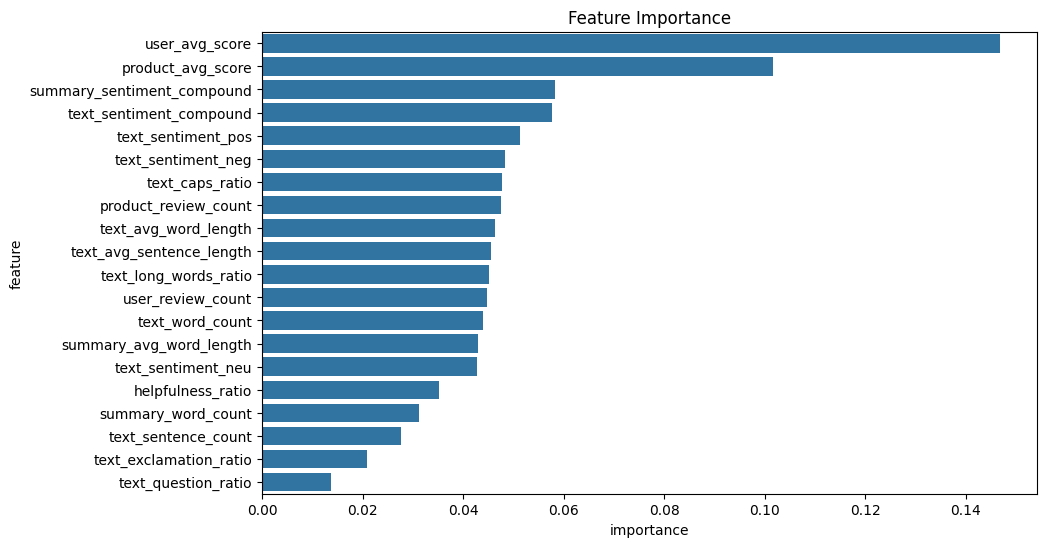

In [6]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_test_scaled = scaler.transform(X_test_split)
X_submission_scaled = scaler.transform(X_submission[feature_columns])

# Train a model to get feature importance
rf_feature = RandomForestClassifier(n_estimators=100, random_state=69, n_jobs=-1)
rf_feature.fit(X_train_scaled, Y_train)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_feature.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

# Model Creation

In [7]:
def create_balanced_pipeline(model):
    """
    Creates a pipeline with SMOTE, undersampling, and the specified model
    """
    return Pipeline([
        ('sampler_over', SMOTE(random_state=RANDOM_SEED)),
        ('sampler_under', RandomUnderSampler(random_state=RANDOM_SEED)),
        ('classifier', model)
    ])

models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_SEED,
        class_weight='balanced',
        n_jobs= -1
    ),
    'LogisticRegression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs= -1
    )
}

# Model Evaluation


Evaluating RandomForest...
RandomForest Accuracy: 0.5722

Evaluating LogisticRegression...
LogisticRegression Accuracy: 0.5574


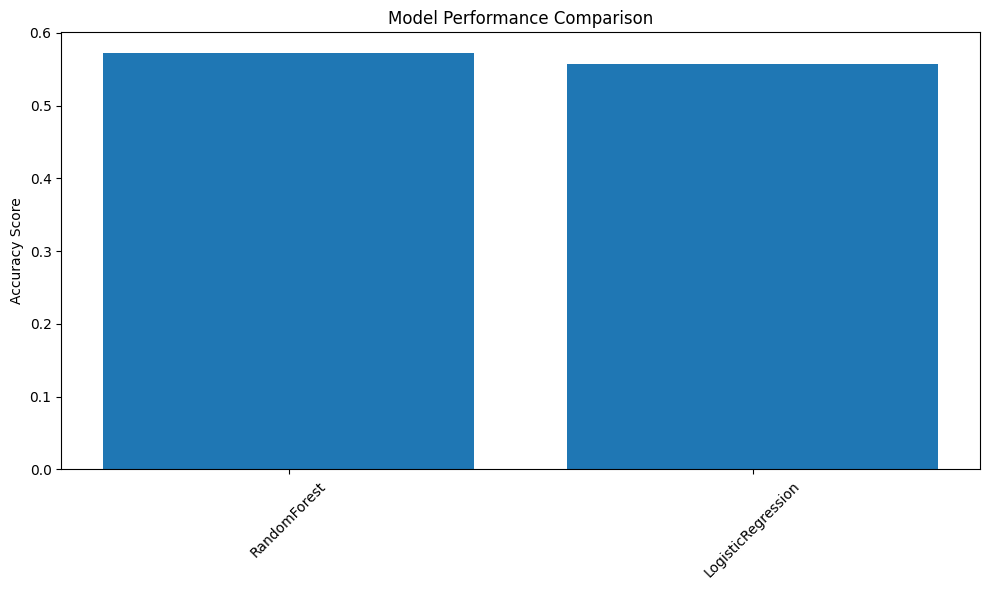


Best model: RandomForest

Performing cross-validation on RandomForest...
Fold 1 Accuracy: 0.5693
Fold 2 Accuracy: 0.5717
Fold 3 Accuracy: 0.5728
Fold 4 Accuracy: 0.5714
Fold 5 Accuracy: 0.5719

Cross-validation scores for RandomForest:
Mean: 0.5714 (+/- 0.0011)

Training final model...


Pipeline(steps=[('sampler_over', SMOTE(random_state=69)),
                ('sampler_under', RandomUnderSampler(random_state=69)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=200,
                                        n_jobs=-1, random_state=69))])

In [8]:
# Quick model comparison without cross-validation
results = {}

# Evaluate each model with simple train/test split
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    try:
        # Create and train pipeline
        pipeline = create_balanced_pipeline(model)
        pipeline.fit(X_train_scaled, Y_train)
        
        # Evaluate
        score = pipeline.score(X_test_scaled, Y_test)
        print(f"{model_name} Accuracy: {score:.4f}")
        
        results[model_name] = {
            'score': score
        }
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")
        continue

# Plot model comparison
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
scores = [results[model]['score'] for model in model_names]

plt.bar(model_names, scores)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find best model
best_model_name = max(results, key=lambda k: results[k]['score'])
print(f"\nBest model: {best_model_name}")

# Optional: Do cross-validation only on the best model
print(f"\nPerforming cross-validation on {best_model_name}...")
best_model = models[best_model_name]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, Y_train)):
    X_fold_train = X_train_scaled[train_idx]
    y_fold_train = Y_train.iloc[train_idx]
    X_fold_val = X_train_scaled[val_idx]
    y_fold_val = Y_train.iloc[val_idx]
    
    pipeline = create_balanced_pipeline(best_model)
    pipeline.fit(X_fold_train, y_fold_train)
    score = pipeline.score(X_fold_val, y_fold_val)
    cv_scores.append(score)
    print(f"Fold {fold + 1} Accuracy: {score:.4f}")

print(f"\nCross-validation scores for {best_model_name}:")
print(f"Mean: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Train final model
print("\nTraining final model...")
final_pipeline = create_balanced_pipeline(models[best_model_name])
final_pipeline.fit(X_train_scaled, Y_train)

# Create submission file

In [10]:
# Make predictions for submission
Y_submission_predictions = final_pipeline.predict(X_submission_scaled)

# Create submission file
submission = pd.DataFrame({
    'Id': testingSet['Id'],
    'Score': Y_submission_predictions
})
submission.to_csv("./data/submission.csv", index=False)
print("Done! Submission file created.")

Done! Submission file created.
